In [1]:
import math
from tensorboardX import SummaryWriter
sess = None

In [2]:
import tensorflow as tf
import collections
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.8)
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v2), EnvSpec(BipedalWalkerHardcore-v2), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v2), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(Hopper-v2), EnvSpec(Swimmer-v2), EnvSpec(Walker2d-v2), EnvSpec(Ant-v2), EnvSpec(Hum

6
done


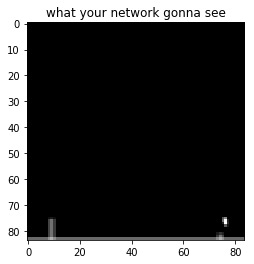

In [4]:
from wrappers import make_env
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
env_name = "PongNoFrameskip-v4"
env_name1 = "BreakoutDeterministic-v4"
env = make_env(env_name)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
print(n_actions)
obs = env.reset()
obs, r, done, _ = env.step(2)
#print(obs.shape)
#print(is_done)
done = False
for _ in range(2000):
    obs, _, done, _ = env.step(3)
    if done:
        print('done')
        break
plt.title("what your network gonna see")
plt.imshow(obs[0,:,:],interpolation='none',cmap='gray');

In [5]:

from dqnagent import DQNAgent
from dqnagent import ExperienceBuffer
EXP_BUFFER_CAPACITY = 100000

#agent.epsilon = 0.5

pong_dqn_config = {
    'GAMMA' : 0.99,
    'LEARNING_RATE' : 1e-4,
    'STEPS_PER_EPOCH' : 1,
    'BATCH_SIZE' : 32,
    'EPSILON' : 0.99,
    'MIN_EPSILON' : 0.02,
    'NUM_EPOCHS' : 9*10**5,
    'NUM_EPOCHS_TO_COPY' : 1000,
    'EPS_DECAY_RATE' : 0.99,
    'NAME' : 'DDDQN',
    'IS_DOUBLE' : False,
    'IS_DUELING' : False,
    'DUELING_TYPE' : 'AVERAGE',
    'SCORE_TO_WIN' : 20
    }
pong_dddqn_config = {
    'GAMMA' : 0.99,
    'LEARNING_RATE' : 1e-4,
    'STEPS_PER_EPOCH' : 1,
    'BATCH_SIZE' : 32,
    'EPSILON' : 0.99,
    'MIN_EPSILON' : 0.02,
    'NUM_EPOCHS' : 9*10**5,
    'NUM_EPOCHS_TO_COPY' : 1000,
    'EPS_DECAY_RATE' : 0.99,
    'NAME' : 'DDDQN',
    'IS_DOUBLE' : False,
    'IS_DUELING' : False,
    'DUELING_TYPE' : 'AVERAGE',
    'SCORE_TO_WIN' : 20
    }
agent = DQNAgent(env, sess, ExperienceBuffer(EXP_BUFFER_CAPACITY), env_name, config = pong_dqn_config)
#agent.restore('nn/DDDQNPongNoFrameskip-v4')
#agent.epsilon = 0.02

In [6]:
env.reset()
agent.train()

0
-21.0
871.0
5000
-20.6666666667
873.0
10000
-21.0
887.0
15000
-21.0
882.0
20000
-20.6666666667
922.0
25000
-20.6666666667
874.0
30000
-19.3333333333
1136.0
35000
-18.6666666667
1243.0
40000
-19.3333333333
1273.66666667
45000
-18.6666666667
1406.33333333
50000
-18.0
1485.33333333
55000
-17.0
1626.33333333
60000
-16.0
1846.0
65000
-16.6666666667
1611.33333333
70000
-18.3333333333
1531.66666667
75000
-17.0
1713.33333333
80000
-18.0
1576.33333333
85000
-17.3333333333
1653.66666667
90000
-18.3333333333
1690.33333333
95000
-16.6666666667
1871.0
100000
-17.0
1927.66666667
105000
-16.0
2068.0
110000
-17.0
1853.0
115000
-14.6666666667
2174.66666667
120000
-16.3333333333
2084.0
125000
-12.6666666667
2219.0
130000
-15.3333333333
1961.66666667
135000
-12.0
2715.66666667
140000
-15.6666666667
2529.66666667
145000
-16.3333333333
2240.66666667
150000
-13.6666666667
2634.0
155000
-12.0
3146.0
160000
-13.6666666667
2576.33333333
165000
-13.6666666667
2545.33333333
170000
-12.6666666667
2761.33333333


In [7]:
#agent.epsilon = 0.2
#agent.train()
import wrappers

In [8]:

print(env.unwrapped.get_action_meanings())
def evaluate(env,t_max=10000):
    rewards = []
    print('reset')
    s = env.reset()
    reward = 0
    for it in range(t_max):
        #e.render()
        qvalues = agent.get_qvalues([s])
        action = np.argmax(qvalues)
        s, r, done, _ = env.step(action)
        reward += r
        rewards.append(reward)
        
            
        if done:
            
            break       
        
    return np.mean(rewards)

import gym.wrappers
env_monitor = make_env(env_name)
env_monitor = gym.wrappers.Monitor(env,directory='video_dddqn',force=True)
sessions = [evaluate(env_monitor) for _ in range(5)]
env_monitor.close()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
reset
reset
reset
reset
reset


In [9]:
#tf.reset_default_graph()
#agent = DQNAgent(env, sess, ExperienceBuffer(EXP_BUFFER_CAPACITY), env_name, config = dqn_config)

In [10]:
#env.reset()
#agent.train()